In [1]:
import argparse
import numpy as np
import pandas as pd
import pickle
import ast, os, sys
import neuroglancer
import matplotlib
from matplotlib import pyplot as plt

In [3]:
PATH = '/home/eddyod/programming/pipeline_utility'
sys.path.append(PATH)
#from utilities.contour_utilities import get_contours_from_annotations, add_structure_to_neuroglancer
neuroglancer.set_server_bind_address(bind_port='33645')

In [4]:
DIR = '/net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes/vol_fill'
ATLAS = 'compressed_atlas.npy'
MD589 = 'MD594_full_filled.npy'
ATLASPATH = os.path.join(DIR, ATLAS)
MD589PATH = os.path.join(DIR, MD589)
atlas = np.load(ATLASPATH)
md589 = np.load(MD589PATH)
atlas = atlas.astype(np.uint8)

In [5]:
atlas.dtype, md589.dtype

(dtype('uint8'), dtype('uint8'))

In [6]:
atlas.shape, md589.shape

((625, 571, 551), (282, 1023, 1585))

In [7]:
vm = np.swapaxes(md589,0,2)
#vol_m = np.swapaxes(vm, 0,1)
#vol_m.shape

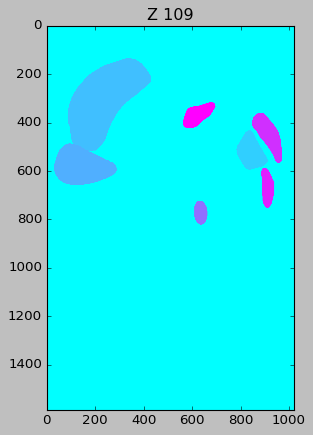

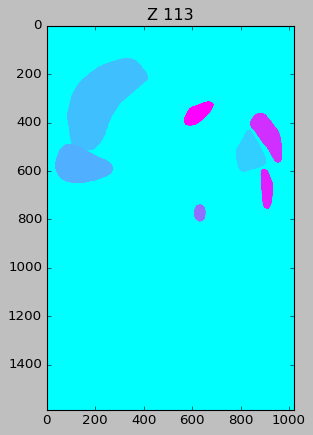

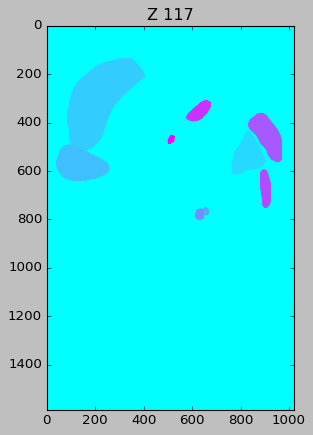

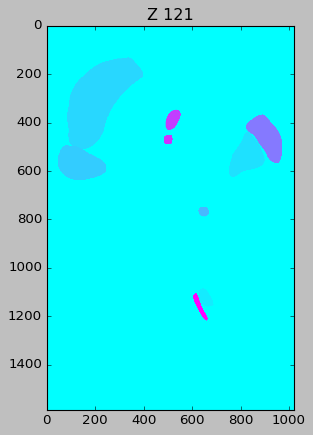

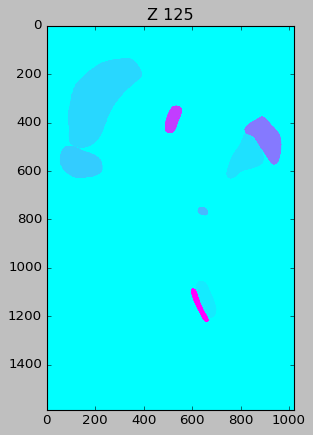

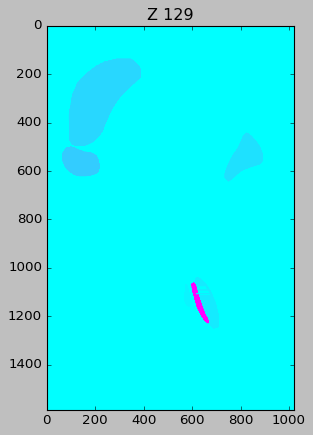

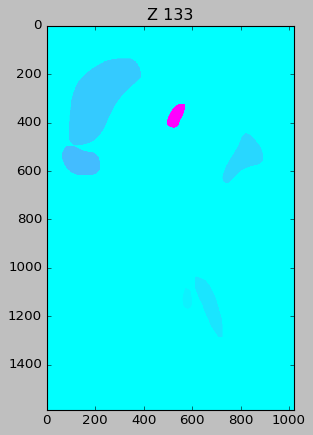

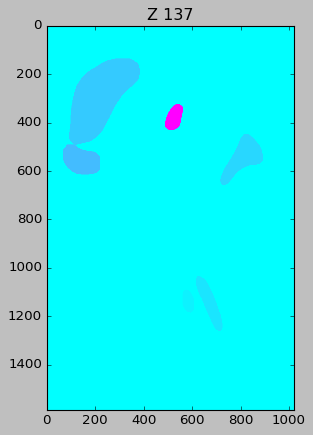

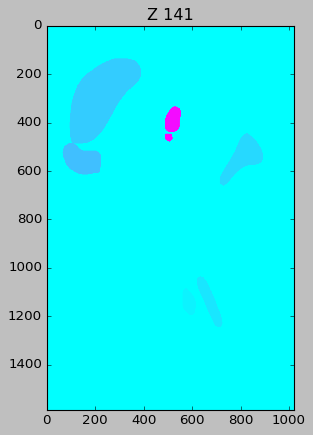

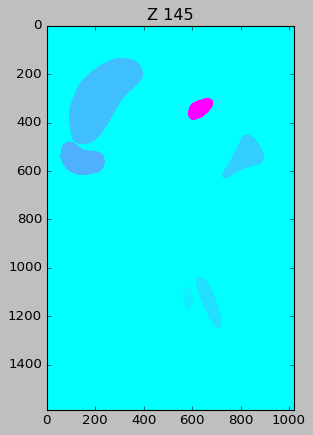

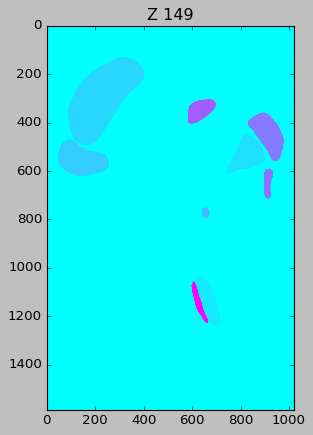

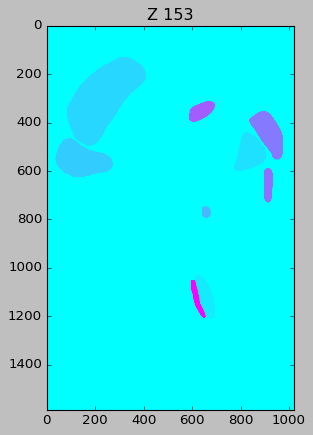

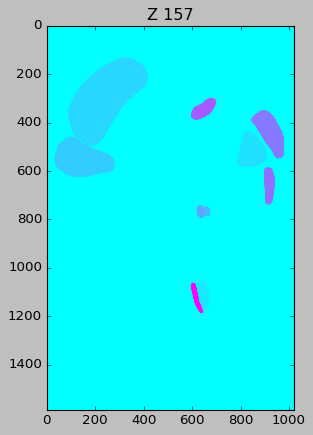

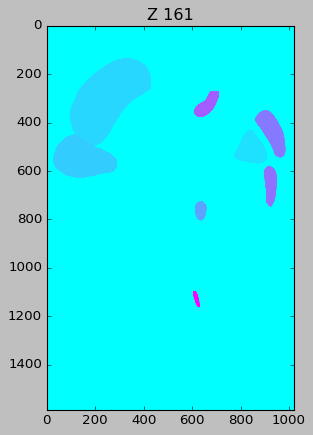

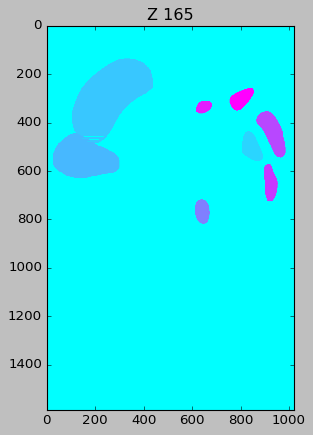

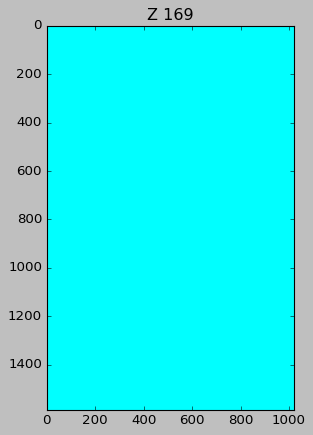

In [8]:
arr = vm
limit = 32
start = (arr.shape[2] // 2) - limit
end = start + limit * 2
nrows = end - start
ncols = 1
plt.style.use('classic')
for i in range(start, end, 4):
    plt.title('Z {}'.format(i))
    plt.imshow(arr[:,:,i], cmap="cool")
    plt.show()

In [ ]:
start

In [ ]:
csvfile = os.path.join(PATH, 'contours', 'hand_annotations.csv')
hand_annotations = pd.read_csv(csvfile)
hand_annotations['vertices'] = hand_annotations['vertices'].apply(lambda x: ast.literal_eval(x))

In [ ]:
animal = 'MD589'
target_structure = '3N'
str_contours_annotation, first_sec, last_sec = get_contours_from_annotations(animal, target_structure, hand_annotations, densify=0)

In [ ]:
viewer = neuroglancer.Viewer()
dimensions = neuroglancer.CoordinateSpace(
    names=['x', 'y', 'z'],
    units='nm',
    scales=[10, 10, 10])

with viewer.txn() as s:
    s.dimensions = dimensions
    s.layers['Altas'] = neuroglancer.ImageLayer(
        source=neuroglancer.LocalVolume(
            data=atlas,
            dimensions=neuroglancer.CoordinateSpace(
                names=['x', 'y', 'z'],
                units=['nm','nm','nm'],
                scales=[5, 5, 5]),
            voxel_offset=(0, 0, 0),
        ),
        shader="""
#uicontrol float min slider(min=0, max=1, default=0)
#uicontrol float max slider(min=0, max=1, default=1)
#uicontrol float invert slider(min=0, max=1, default=0, step=1)
#uicontrol float brightness slider(min=-1, max=1)
#uicontrol float contrast slider(min=-3, max=3, step=0.01)
void main() {
  float pix_val = toNormalized(getDataValue());
  if(pix_val < min){
  	pix_val = 0.0;
  }
  if(pix_val > max){
    pix_val = 1.0;
  }

  if(invert==1.0){
  	  emitGrayscale((1.0 -(pix_val - brightness)) *
       exp(contrast));
  }
  else{
    emitGrayscale((pix_val + brightness) *
                  exp(contrast));
  }

}

""")
print(viewer)

In [ ]:
color = 2
ng_structure_volume = add_structure_to_neuroglancer(viewer, str_contours_annotation, target_structure, animal, first_sec, last_sec, \
                                                    color_radius=2, xy_ng_resolution_um=5, threshold=1, color=color, \
                                                    solid_volume=False, no_offset_big_volume=True, save_results=False, \
                                                    return_with_offsets=False, add_to_ng=True, human_annotation=True )


In [ ]:
print('ng_structure_volume shape', ng_structure_volume.shape)
print('ng_structure_volume max', np.amax(ng_structure_volume))